In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
from datetime import datetime
import boto3
from botocore.exceptions import ClientError
from io import StringIO
import re
# from fastparquet import ParquetFile
# import s3fs
# from cleodata.utils.secrets import get_secret
# from cleodata.sources.sync.sync import SyncDataSource
# boto3.setup_default_session(profile_name='DataScientist-878877078763')
# redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [3]:
from sagemaker import get_execution_role
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
def read_from_s3(path):
    """Read parquet files and combine them into a single dataframe"""
    fs = s3fs.core.S3FileSystem()
    all_paths_from_s3 = fs.glob(path=f"{path}*.parquet")

    if len(all_paths_from_s3) > 0:
        s3 = s3fs.S3FileSystem()
        fp_obj = ParquetFile(
            all_paths_from_s3, open_with=s3.open
        )  # use s3fs as the filesystem
        data = fp_obj.to_pandas()
        return data
    elif len(all_paths_from_s3)==1:
        return pd.read_parquet(all_paths_from_s3[0])
    else:
        print(f"Nothing found")
        print(f"paths from a{all_paths_from_s3}")
    
def read_csv_s3(bucket, key):
    try:
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'])
        return df
    except ClientError as ex:
        if ex.response['Error']['Code'] == 'NoSuchKey':
            print("Key doesn't match. Please check the key value entered.")


# Create positive and negative data pairs

In [6]:
%pip install pyarrow
%pip install fastparquet
%pip install awswrangler

Note: you may need to restart the kernel to use updated packages.
  Using cached fastparquet-2024.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached cramjam-2.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached fastparquet-2024.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
Using cached cramjam-2.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import awswrangler as wr

In [8]:
path_new_file = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14"
df_data_raw = wr.s3.read_parquet(path=path_new_file)

In [9]:
path_new_file

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14'

In [10]:
path_file_out = path_new_file.split('processed/')[0]+'trx-merchant-pair/'+path_new_file.split('processed/')[1]
path_file_out

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14'

In [12]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel
0,9815919398,2024-05-14,-6.99,APPLE.COM/BILL 866-712-7753 CA,Apple,APPLE.COM/BILL 866-712- CA,APPLE.COM/BILL 866-712- CA. Channel: online. A...,APPLE.COM/BILL 866-712- CA. Type: merchant. Ch...,online
1,9815920122,2024-05-14,500.00,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,U.S. Bank,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,other
2,9815920123,2024-05-14,-50.00,Debit Purchase -visa Betmgm Online 4233451561 ...,BetMGM,Debit Purchase -visa Betmgm Online Nj 05/10 Card,Debit Purchase -visa Betmgm Online Nj 05/10 Ca...,Debit Purchase -visa Betmgm Online Nj 05/10 Ca...,online
3,9815920127,2024-05-14,-30.00,Debit Purchase -visa Fanduelsbkprimar971708301...,FanDuel Sportsbook,Debit Purchase -visa Fanduelsbkprimar Nj 05/13...,Debit Purchase -visa Fanduelsbkprimar Nj 05/13...,Debit Purchase -visa Fanduelsbkprimar Nj 05/13...,in store
4,9815942915,2024-05-14,-85.00,Transfer From Varo Savings Account To Varo Ban...,Varo,Transfer From Varo Savings Account To Varo Ban...,Transfer From Varo Savings Account To Varo Ban...,Transfer From Varo Savings Account To Varo Ban...,other


In [10]:
print(df_data_raw['sentence'][1000050], df_data_raw['merchant_name_combined'][1000050])

CASEY S # TR CLARKSVILLE TN 05/11. Channel: in store. Amount: -4.13 Casey''s


In [11]:
df_data_raw['num_words'] = df_data_raw['description_combined_processed'].apply(lambda x: len(x.split(' ')))

In [12]:
df_data_raw['num_words'].describe()

count    4.616236e+06
mean     8.933722e+00
std      3.504063e+00
min      1.000000e+00
25%      6.000000e+00
50%      9.000000e+00
75%      1.100000e+01
max      8.200000e+01
Name: num_words, dtype: float64

In [13]:
df_data_raw['num_words'].max()*3

246

In [14]:
df_data_raw[df_data_raw['num_words']==82]

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,original_description_plaid_processed,sentence,sentence2,payment_channel,num_words
1600443,9777852744,2024-05-13,-20.26,Withdrawal Ach Circle K Gulf Co Location - Cir...,Circle K,Withdrawal Ach Circle K Gulf Co Location - Cir...,Withdrawal Ach Circle K Gulf Co Location - Cir...,Withdrawal Ach Circle K Gulf Co Location - Cir...,online,82


In [15]:

df_data_raw.loc[1600443,'description_combined_processed']

'Withdrawal Ach Circle K Gulf Co Location - Circle K - G- Cottage H Mobile Al / Terminal Id: Type: Preauthpmt Id: Data: 4Info 877-403 Location - Circle K - G- Cottage H Mobile Al / Terminal Id: Type: Preauthpmt Id: Data: 4Info 877-403 Location - Circle K - G- Cottage H Mobile Al / Terminal Id: Type: Preauthpmt Id: Data: 4Info 877-403 Location - Circle K - G- Cottage H Mobile Al / Terminal Id: Type: Preauthpmt Id: Data: 4Info 877-403'

In [16]:
df_data_raw.loc[1600443,'description_combined']

'Withdrawal Ach Circle K Gulf Co Location - Circle K - G-8775 Cottage H Mobile Al / Terminal Id: 26916 Type: Preauthpmt Id: 1741149540 Data: 4Info 877-403 Location - Circle K - G-8775 Cottage H Mobile Al / Terminal Id: 26916 Type: Preauthpmt Id: 1741149540 Data: 4Info 877-403 Location - Circle K - G-8775 Cottage H Mobile Al / Terminal Id: 26916 Type: Preauthpmt Id: 1741149540 Data: 4Info 877-403 Location - Circle K - G-8775 Cottage H Mobile Al / Terminal Id: 26916 Type: Preauthpmt Id: 1741149540 Data: 4Info 877-403'

In [17]:
df_data_raw.loc[1600443,'merchant_name_combined']

'Circle K'

In [18]:
df_data_raw['len_sentence'] = df_data_raw['sentence'].apply(lambda x: len(x.split(' ')))

In [19]:
df_data_raw['len_sentence'].max()

86

In [20]:
df_data_raw.head()

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,original_description_plaid_processed,sentence,sentence2,payment_channel,num_words,len_sentence
0,9815920130,2024-05-13,300.0,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,U.S. Bank,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,Atm Deposit Us Bank Hermitaghermitage Tnus1 05...,other,9,13
1,9815920158,2024-05-13,-18.6,Recurring Debit Purchase Apple.com/bill 866-71...,Apple,Recurring Debit Purchase Apple.com/bill 866-71...,Recurring Debit Purchase Apple.com/bill 866-71...,Recurring Debit Purchase Apple.com/bill 866-71...,online,9,13
2,9815920131,2024-05-13,-100.0,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,U.S. Bank,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,other,9,13
3,9815920132,2024-05-13,-20.0,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,U.S. Bank,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,other,9,13
4,9815920133,2024-05-13,-20.0,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,U.S. Bank,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,Atm Withdrawal Us Bank Hermitaghermitage Tnus1...,other,9,13


In [28]:
print(df_data_raw[df_data_raw['len_sentence']==df_data_raw['len_sentence'].max()]['description_combined'])

1600443    Withdrawal Ach Circle K Gulf Co Location - Cir...
Name: description_combined, dtype: string


In [29]:
df_merchant_volume = df_data_raw['merchant_name_combined'].value_counts(dropna=False).to_frame()
df_merchant_volume

,count
merchant_name_combined,
Cash App,352253
Zelle,241516
Earnin,124568
Amazon,101402
Walmart,95355
...,...
Trapper''s Fish Camp,1
Wayne Drug A Health Mart Pharmacy,1
Brixx Pizza Ft,1


In [30]:
n_tot_trans  = df_data_raw.shape[0]
df_merchant_volume['perc_traffic'] = df_merchant_volume['count']/n_tot_trans
df_merchant_volume.sort_values(by='perc_traffic', ascending=False)
df_merchant_volume['cumulative_traffic'] = df_merchant_volume['perc_traffic'].cumsum()
df_merchant_volume

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Cash App,352253,0.076307,0.076307
Zelle,241516,0.052319,0.128626
Earnin,124568,0.026985,0.155611
Amazon,101402,0.021966,0.177577
Walmart,95355,0.020656,0.198234
...,...,...,...
Trapper''s Fish Camp,1,0.0,0.999999
Wayne Drug A Health Mart Pharmacy,1,0.0,0.999999
Brixx Pizza Ft,1,0.0,1.0


In [31]:
df_merchant_volume[0:1000]

,count,perc_traffic,cumulative_traffic
merchant_name_combined,,,
Cash App,352253,0.076307,0.076307
Zelle,241516,0.052319,0.128626
Earnin,124568,0.026985,0.155611
Amazon,101402,0.021966,0.177577
Walmart,95355,0.020656,0.198234
...,...,...,...
99 Ranch Market,184,0.00004,0.770511
LinkedIn,184,0.00004,0.770551
Market Work,183,0.00004,0.77059


(0.0, 4000.0)

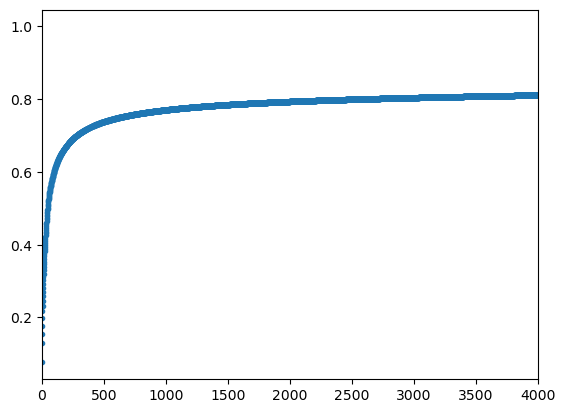

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(df_merchant_volume.shape[0]),df_merchant_volume['cumulative_traffic'],'.')
plt.xlim([0,4000])

In [33]:
df_merchant_volume.reset_index(drop=False,inplace=True)
df_merchant_volume

,merchant_name_combined,count,perc_traffic,cumulative_traffic
0,Cash App,352253,0.076307,0.076307
1,Zelle,241516,0.052319,0.128626
2,Earnin,124568,0.026985,0.155611
3,Amazon,101402,0.021966,0.177577
4,Walmart,95355,0.020656,0.198234
...,...,...,...,...
492810,Trapper''s Fish Camp,1,0.0,0.999999
492811,Wayne Drug A Health Mart Pharmacy,1,0.0,0.999999
492812,Brixx Pizza Ft,1,0.0,1.0
492813,Lighthouse Restaurant & Event Center,1,0.0,1.0


In [104]:
top_n = 101
merchants_top_n = df_merchant_volume['merchant_name_combined'][0:top_n].tolist()
print(len(merchants_top_n))
merchants_top_n

101


['Cash App',
 'Zelle',
 'Earnin',
 'Amazon',
 'Walmart',
 "McDonald''s",
 'Cleo',
 'Apple',
 'Apple Cash',
 'Venmo',
 'Wells Fargo',
 'MoneyLion',
 'Dave',
 'Shell',
 'Empower',
 '7-Eleven',
 'Brigit',
 'Circle K',
 'Uber',
 'Dollar General',
 'Target',
 'Albert',
 'Starbucks',
 'Bank of America',
 'AfterPay',
 'Affirm',
 'Klover App',
 'Chick-fil-A',
 "Dunkin''",
 'Klarna',
 'Dollar Tree',
 'Taco Bell',
 'PayPal',
 'Uber Eats',
 'Zip.co',
 'Walgreens',
 'Amazon Prime',
 'FanDuel Sportsbook',
 'Sezzle',
 'QuikTrip',
 'Lyft',
 'Chevron',
 'BP',
 'Capital One',
 'DraftKings',
 'FloatMe',
 'Kroger',
 "Wendy''s",
 'Publix',
 'Speedway',
 'CVS',
 'Wawa',
 'Chase Bank',
 'Burger King',
 'Family Dollar',
 'Instacart',
 'Sunoco',
 '365 Retail Markets',
 'ExxonMobil',
 'Amazon Prime Video',
 'Sonic Drive-In',
 'T-Mobile',
 'Sheetz',
 'Safeway',
 'Food Lion',
 "Casey''s",
 'Netflix',
 "Domino''s",
 'Murphy USA',
 'RaceTrac',
 'H-E-B',
 'Chipotle Mexican Grill',
 'Grid',
 'OnlyFans',
 "Sam''s Clu

In [105]:
24*100/3600

0.6666666666666666

In [106]:
20*50/3600

0.2777777777777778

In [107]:
166/60

2.7666666666666666

In [108]:
18*60*10*5/3600

15.0

In [109]:
# !pwd
# !ls -ltr /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History
# !more /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/14a6abb3/entries.json
# !touch /opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/
# !touch /home/sagemaker-user/toto
# !echo "abdc" > /home/sagemaker-user/toto
# !more /home/sagemaker-user/toto

In [110]:
!pip install path

In [111]:
from path import Path

In [112]:
path_new_file

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-13_2024-05-13'

In [113]:
path_new_file

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-13_2024-05-13'

In [114]:
#This step needs to be parallelized
n_pairs = 5000
df_all = pd.DataFrame()
for i,merchant in enumerate(merchants_top_n):
  print(i,merchant)
  df_s1 = df_data_raw[df_data_raw['merchant_name_combined']==merchant][['transaction_id','sentence','sentence2','description_combined_processed','merchant_name_combined']]
  df_s1.rename(columns={'merchant_name_combined':'true_merchant_name_combined'}, inplace=True)
  df_s2 = df_data_raw[df_data_raw['merchant_name_combined']!=merchant][['transaction_id','merchant_name_combined']]
  df_negative = pd.concat([df_s1.sample(min(df_s1.shape[0],2*n_pairs),random_state=1)[['transaction_id','sentence','sentence2','description_combined_processed','true_merchant_name_combined']].reset_index(drop=True), \
                           df_s2.sample(min(df_s1.shape[0],2*n_pairs), random_state=1)[['merchant_name_combined']].reset_index(drop=True)], axis=1 , ignore_index=True)
  df_negative['true_label'] = 0
  df_negative['label'] = 0 + np.abs(np.random.normal(0,0.2,[1,df_negative.shape[0]])[0])
  df_negative.columns = ['transaction_id','sentence','sentence2','description_combined_processed','true_merchant_name_combined','merchant_name_combined','true_label','label']
  df_positive = df_s1.sample(min(df_s1.shape[0],n_pairs), random_state=1)
  df_positive['true_label'] = 1
  df_positive['label'] = 1 - np.abs(np.random.normal(0,0.2,[1,df_positive.shape[0]])[0])
  df_positive['merchant_name_combined'] = df_positive['true_merchant_name_combined']
  df_all = pd.concat([df_all, df_negative, df_positive[['transaction_id','sentence','sentence2','description_combined_processed','true_merchant_name_combined','merchant_name_combined','true_label','label']] ], axis=0)
  #!echo "abdc" > /home/sagemaker-user/toto
  if i%50 == 0:
    Path("/opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/reset_timer.txt").touch()
  if i%10 == 0:
    print('saving')
    print(i)
    s3_path_out = path_file_out+'_top_'+str(top_n)+'_'+str(i)+'.parquet'
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sample.parquet"
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/transactions_2024-05-20_2024-05-20_"+str(i)+".parquet"
    #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sm_test.parquet"
    df_all.to_parquet(s3_path_out, engine='pyarrow')
    print(i, s3_path_out)





0 Cash App
saving
0
0 s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101_0.parquet
1 Zelle
2 Earnin
3 Amazon
4 Walmart
5 McDonald''s
6 Cleo
7 Apple
8 Apple Cash
9 Venmo
10 Wells Fargo
saving
10
10 s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101_10.parquet
11 MoneyLion
12 Dave
13 Shell
14 Empower
15 7-Eleven
16 Brigit
17 Circle K
18 Uber
19 Dollar General
20 Target
saving
20
20 s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101_20.parquet
21 Albert
22 Starbucks
23 Bank of America
24 AfterPay
25 Affirm
26 Klover App
27 Chick-fil-A
28 Dunkin''
29 Klarna
30 Dollar Tree
saving
30
30 s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101_30.parquet
31 Taco Bell
32 PayPal
33 Uber Eats
34 Zip.co
35 Walgreens

In [119]:
s3_path_out

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101.parquet'

In [116]:
df_all.shape

(1401818, 8)

In [117]:
df_all

,transaction_id,sentence,sentence2,original_description_plaid_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
0,9823228670,CASH APP*DAWN MILLS 800- CA 05/11. Channel: No...,CASH APP*DAWN MILLS 800- CA 05/11. Type: payme...,CASH APP*DAWN MILLS 800- CA 05/11,Cash App,Dollar Tree,0,0.050593
1,9782646513,Cash App*Jaycee Hall. Channel: None. Amount: -...,Cash App*Jaycee Hall. Type: payment_app. Chann...,Cash App*Jaycee Hall,Cash App,Earnin,0,0.026283
2,9889714757,CASH APP*TINA VANCE San Francisc. Channel: Non...,CASH APP*TINA VANCE San Francisc. Type: paymen...,CASH APP*TINA VANCE San Francisc,Cash App,Jordan''s Kwik Stop,0,0.326722
3,9781579970,Cash App*Jefe*Add Cash. Channel: None. Amount:...,Cash App*Jefe*Add Cash. Type: payment_app. Cha...,Cash App*Jefe*Add Cash,Cash App,Apple,0,0.069118
4,9791996406,CASH APP*SATIVAA WATTS 800- CA 05/12. Channel:...,CASH APP*SATIVAA WATTS 800- CA 05/12. Type: pa...,CASH APP*SATIVAA WATTS 800- CA 05/12,Cash App,Zip.co,0,0.033212
...,...,...,...,...,...,...,...,...
1213821,9780923424,Citgo Guru Hari. Channel: in store. Amount: -2.45,Citgo Guru Hari. Type: merchant. Channel: in s...,Citgo Guru Hari,Citgo,Citgo,1,0.599629
4604133,9780799982,Westville Citgo. Channel: in store. Amount: -5.62,Westville Citgo. Type: merchant. Channel: in s...,Westville Citgo,Citgo,Citgo,1,0.833770
1997485,9781845116,Lebanon Citgo. Channel: in store. Amount: -4.23,Lebanon Citgo. Type: merchant. Channel: in sto...,Lebanon Citgo,Citgo,Citgo,1,0.739783
2412261,9795690212,PURCHASE AUTHORIZED ON 05/13 CITGO GEORGIA FO ...,PURCHASE AUTHORIZED ON 05/13 CITGO GEORGIA FO ...,PURCHASE AUTHORIZED ON 05/13 CITGO GEORGIA FO ...,Citgo,Citgo,1,0.983746


In [118]:
s3_path_out = path_file_out+'_top_'+str(top_n)+'.parquet'
df_all.to_parquet(s3_path_out, engine='pyarrow')
print(f"Finished creating {s3_path_out}")
df_data_pairs = wr.s3.read_parquet(path=s3_path_out)


Finished creating s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-13_2024-05-13_top_101.parquet


In [68]:
df_data_pairs

,transaction_id,sentence,sentence2,original_description_plaid_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
0,9823228670,CASH APP*DAWN MILLS 800- CA 05/11. Channel: No...,CASH APP*DAWN MILLS 800- CA 05/11. Type: payme...,CASH APP*DAWN MILLS 800- CA 05/11,Cash App,Dollar Tree,0,0.137544
1,9782646513,Cash App*Jaycee Hall. Channel: None. Amount: -...,Cash App*Jaycee Hall. Type: payment_app. Chann...,Cash App*Jaycee Hall,Cash App,Earnin,0,0.321287
2,9889714757,CASH APP*TINA VANCE San Francisc. Channel: Non...,CASH APP*TINA VANCE San Francisc. Type: paymen...,CASH APP*TINA VANCE San Francisc,Cash App,Jordan''s Kwik Stop,0,0.240293
3,9781579970,Cash App*Jefe*Add Cash. Channel: None. Amount:...,Cash App*Jefe*Add Cash. Type: payment_app. Cha...,Cash App*Jefe*Add Cash,Cash App,Apple,0,0.221128
4,9791996406,CASH APP*SATIVAA WATTS 800- CA 05/12. Channel:...,CASH APP*SATIVAA WATTS 800- CA 05/12. Type: pa...,CASH APP*SATIVAA WATTS 800- CA 05/12,Cash App,Zip.co,0,0.090633
5,9776706264,CASH APP*BIO*CASH OUT San FranciscoCAUS. Chann...,CASH APP*BIO*CASH OUT San FranciscoCAUS. Type:...,CASH APP*BIO*CASH OUT San FranciscoCAUS,Cash App,Hibachio,0,0.249232
6,9795519894,VISA DDA PUR AP CASH APP CHRISTOPER 800 * CA. ...,VISA DDA PUR AP CASH APP CHRISTOPER 800 * CA. ...,VISA DDA PUR AP CASH APP CHRISTOPER 800 * CA,Cash App,Publix,0,0.145249
7,9791055251,PMNT SENT CASH APP*DOZEN*ADD CASH XXX-XX CA XX...,PMNT SENT CASH APP*DOZEN*ADD CASH XXX-XX CA XX...,PMNT SENT CASH APP*DOZEN*ADD CASH XXX-XX CA XX...,Cash App,Supermarcado Th,0,0.588851
8,9798414621,Debit Purchase -visa Cash App*leah Ow800- Ca 0...,Debit Purchase -visa Cash App*leah Ow800- Ca 0...,Debit Purchase -visa Cash App*leah Ow800- Ca 0...,Cash App,Tulsa Technology Center,0,0.059567
9,9785862397,POS PUR- ***** 05/12 / 05:26 CASH APP*JULIO H ...,POS PUR- ***** 05/12 / 05:26 CASH APP*JULIO H ...,POS PUR- ***** 05/12 / 05:26 CASH APP*JULIO H ...,Cash App,Better Buzz,0,0.282001


In [50]:
# s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sample.parquet"
# df_all.to_parquet(s3_path_out, engine='pyarrow')



In [ ]:
Path("/opt/amazon/sagemaker/sagemaker-code-editor-server-data/data/User/History/reset_timer.txt").touch()

In [ ]:
  # s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/transactions_2024-05-20_2024-05-20_top5K.parquet"
  # #s3_path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/sm_test.parquet"
  # df_all.to_parquet(s3_path_out, engine='pyarrow')

In [ ]:
print("finished")

finished


In [ ]:
df_all.shape

(90, 6)

In [ ]:
df_all.reset_index(drop=True, inplace=True)

In [ ]:
df_all.head()

,transaction_id,sentence,sentence2,merchant_name_combined,true_label,label
0,9856397567,Cash App*Katelyn Vega Channel: None. Amount: -...,Cash App*Katelyn Vega Type: payment_app Channe...,McDonald''s,0,0.122509
1,9860053436,MONEY TRANSFER AUTHORIZED ON 05/19 CASH APP*ST...,MONEY TRANSFER AUTHORIZED ON 05/19 CASH APP*ST...,Walmart,0,0.127154
2,9849592429,Check Card Debit CASH APP*DESTINEE CHAR SAN F...,Check Card Debit CASH APP*DESTINEE CHAR SAN F...,Uber,0,0.137196
3,9862154091,CASH APP*WILLIAM PRICE* San FranciscoCA Channe...,CASH APP*WILLIAM PRICE* San FranciscoCA Type: ...,Brigit,0,0.274984
4,9860580476,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*RA...,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*RA...,Round Up,0,0.233289


In [ ]:
df_all.loc[0,'sentence']

'Cash App*Katelyn Vega Channel: None. Amount: -30.00'

In [ ]:
df_all.loc[0,'sentence2']

'Cash App*Katelyn Vega Type: payment_app Channel: None. Amount: -30.00'

In [ ]:
# df_all.to_csv("/Users/claracastellanos/Documents/DATA/MERCHANTS/2024_05_20_sample_top5K_pairs.csv")

In [ ]:
print(f"Finished creating file")

Finished creating file


In [ ]:
#write this data to s3

In [ ]:
df_all.head(20)

,transaction_id,sentence,merchant_name_combined,true_label,label
0,9861390363,CHECKCARD 0517 CASH APP*MARIO*AD XXXXX91940 CA...,Food Lion,0,0.060653
1,9863465715,Cash App Transfer to Christoph other 0 ...,Zealchurch.co,0,0.014648
2,9869624532,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*TA...,Publix,0,0.011352
3,9868732447,MONEY TRANSFER AUTHORIZED ON 05/17 CASH APP*ZI...,RaceTrac,0,0.401207
4,9851739256,Cash app*um daddy*cash san franciscocaus other...,AfterPay,0,0.010773
5,9861987135,Transfer from Cash App other 0 25.00...,MoneyLion,0,0.117875
6,9859650459,3836 CASH APP*SILVESTER F52 San Francisco CA 9...,Dollar Tree,0,0.031189
7,9862651079,MONEY TRANSFER AUTHORIZED ON 05/18 CASH APP*JO...,Albert,0,0.165105
8,9864106688,CASH APP*CRYSTAL WAR SAN FRANCISCO CA256098 05...,Chatur,0,0.450697
9,9861917121,"DEBIT CARD PURCHASE AT CASH APP*MATTHEW R, SAN...",Tree House,0,0.003653
